# File and libraries

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

filepath=r'dataset/df_msg_feat_eng_input'

file_tag = "df_msg_feat_eng_input"

# DSLabs functions

In [13]:
%run "scripts/dslabs_functions.py"


dslabs lodaded


# Data functions

In [14]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [15]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    sample=0.05
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    
    
else:
    data=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)



 
target='is_clicked'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39618 entries, 68737 to 792285
Data columns (total 42 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   platform                                 39618 non-null  float64
 1   email_provider                           39618 non-null  float64
 2   campaign_type                            39618 non-null  float64
 3   channel_cmp                              39618 non-null  float64
 4   topic                                    39618 non-null  float64
 5   total_count                              39618 non-null  float64
 6   subject_length                           39618 non-null  float64
 7   day_of_year                              39618 non-null  float64
 8   month                                    39618 non-null  float64
 9   days_diff_opened_first_time_at_sent_at   39618 non-null  float64
 10  days_diff_clicked_first_time_at_sent_at  39618

# Balancing Analysis

Minority class= 1.0 : 1495
Majority class= 0.0 : 38123
Proportion: 0.04 : 1


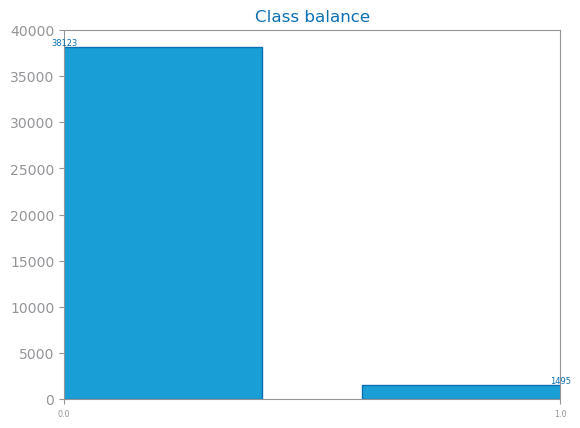

In [16]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart


target_count: Series = data[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

print(f"Original class distribution:\n{data[target].value_counts(normalize=True) * 100}\n")


figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

# Balance 1 - Undersampling
undersample a 60 mas se calhar podem fazer um pouco mais alto

## Bal 1 strategy Application

In [17]:
from pandas import DataFrame, Series
from sklearn.preprocessing import StandardScaler



def apply_strategy_1(df: DataFrame) -> DataFrame:

    df_copy=df.copy()

    # this script is available in data_functions originally from DSLabs site in Outlier chapter

    # Ensure positive_class and negative_class are defined and match the target values
    positive_class = 1  # Or whatever your positive class value is
    negative_class = 0  # Or whatever your negative class value is

    # Separate the majority and minority classes
    df_majority = df_copy[df_copy[target] == negative_class]
    df_minority = df_copy[df_copy[target] == positive_class]

    # Check the class distribution
    print(f"Original class distribution:\n{df_copy[target].value_counts(normalize=True) * 100}\n")

    # Downsample the majority class to match the size of the minority class
    df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

    # Combine the downsampled majority class with the minority class
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    # Shuffle the combined dataset
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    df_balanced.sort_values(by='day_of_year', inplace=True)
    

    # Check the new class distribution to verify the balance
    print(f"Balanced class distribution:\n{df_balanced[target].value_counts(normalize=True) * 100}\n")

    
    return df_balanced


data_1=apply_strategy_1(data)




Original class distribution:
is_unsubscribed
0.0    96.226463
1.0     3.773537
Name: proportion, dtype: float64

Balanced class distribution:
is_unsubscribed
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64



## Bal 1 train/test split 

Labels=[0.0, 1.0]


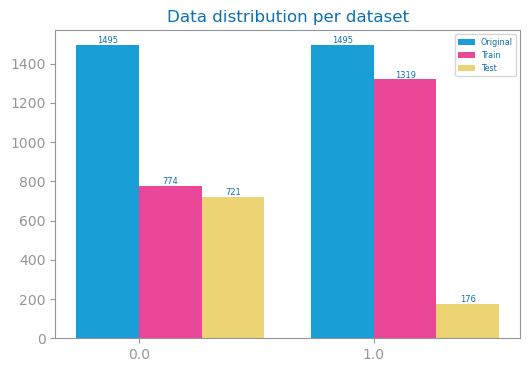

In [18]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart


# Call the function to split the data
y_1, X_1, labels, values = define_target_and_prepare_data(data_1, target)


train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=data_1.columns), y_1, data_columns=data_1.columns, target_column=target)

# Distribution check
values["Train"] = [
    len(train_1[train_1[target] == 0]),
    len(train_1[train_1[target] == 1]),
]
values["Test"] = [
    len(test_1[test_1[target] == 0]),
    len(test_1[test_1[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

## Bal 1 evaluate

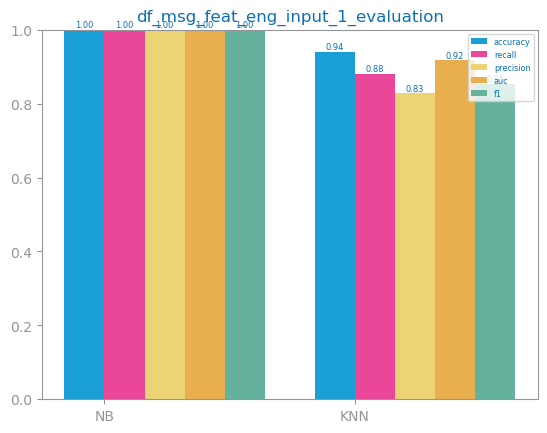

In [19]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

figure()
eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='is_unsubscribed', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_1, title=f"{file_tag}_1_evaluation", percentage=True
)
savefig(f"images/{file_tag}_1_evaluation.png")
show()

# Bal 2 - SMOTE


## Bal 2 strategy aplication

In [20]:
from numpy import ndarray
from pandas import Series
from imblearn.over_sampling import SMOTE

def apply_strategy_2(df):

   # Copy the DataFrame
    df_copy = df.copy()

    # Define random state for reproducibility
    RANDOM_STATE = 42

    # Separate the features (X) and target (y)
    y = df_copy.pop(target).values
    X: ndarray = df_copy.values

    # Initialize SMOTE
    smote = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)

    # Fit and resample
    smote_X, smote_y = smote.fit_resample(X, y)

    # Reconstruct the DataFrame from the SMOTE output
    df_smote = concat([DataFrame(smote_X, columns=df_copy.columns), DataFrame(smote_y, columns=[target])], axis=1)


    # Print class distribution and shape
    smote_target_count: Series = Series(smote_y).value_counts()
    print("Minority class=", smote_target_count.index[1], ":", smote_target_count[1])
    print("Majority class=", smote_target_count.index[0], ":", smote_target_count[0])
    print(
        "Proportion:",
        round(smote_target_count[1] / smote_target_count[0], 2),
        ": 1",
    )
    print("Shape of the new DataFrame:", df_smote.shape)

    print("Class counts after SMOTE:")
    print(df_smote[target].value_counts())

    return df_smote

data_2=data.copy()
data_2=apply_strategy_2(data_2)


Minority class= 1.0 : 38123
Majority class= 0.0 : 38123
Proportion: 1.0 : 1
Shape of the new DataFrame: (76246, 42)
Class counts after SMOTE:
is_unsubscribed
0.0    38123
1.0    38123
Name: count, dtype: int64


## Bal 2 train/test split 

Labels=[0.0, 1.0]


<Axes: title={'center': 'Data distribution per dataset'}>

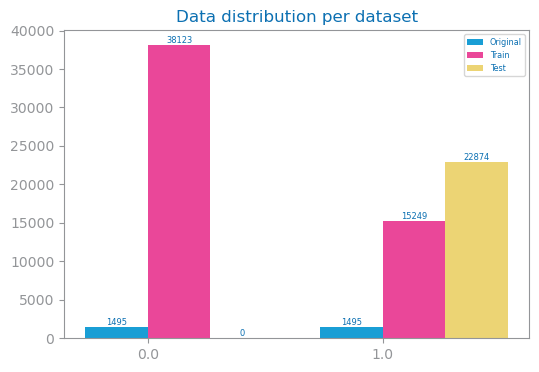

In [21]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart

# train/test split from DSLABS Classification/Evaluation Chapter
# created split_data_save_csv on data_functions

# Call the function to split the data
y_2, X_2, labels, class_counts = define_target_and_prepare_data(data_2, target=target)

train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=data_2.columns), y_2, data_columns=data_2.columns, target_column=target)


values["Train"] = [
    len(train_2[train_2[target] == 0]),
    len(train_2[train_2[target] == 1]),
]
values["Test"] = [
    len(test_2[test_2[target] == 0]),
    len(test_2[test_2[target] == 1]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")

## Bal 2 evaluate

In [22]:

figure()
eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_unsubscribed', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_2, title=f"{file_tag}_2_evaluation", percentage=True
)
savefig(f"images/{file_tag}_2_evaluation.png")
show()

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

<Figure size 640x480 with 0 Axes>

# Approach uplift comparison

## uplift df

In [ ]:
algorithms = ['Naive Bayes', 'KNN']

# Create DataFrames for eval_1 and eval_2
df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

# Calculate uplift
df_uplift = df_eval_2 - df_eval_1



# Combine everything into one DataFrame (without misalignment issues)
comparison_df = pd.concat([df_eval_1, df_eval_2, df_uplift], axis=1)
comparison_df.columns = pd.MultiIndex.from_product([['Approach 1', 'Approach 2', 'Uplift'], eval_1.keys()])



# Display the DataFrame
comparison_df

# Analysis

- Uplift between outlier input approaches is specially significant when it comes to recall (55.7%  out1 to 37% out2). 
- Accuracy however is lower on out1 vs out2 treatment strategies
- data processing time is almost equal
- Considering out1 is the best between both strategies, if we compare between previous dataset and outlier treatment, we have
    - an improvement in NB recall (0.35 to 0.55!)
    - slight loss in NB accuracy: 0.63 to 0.59 
    - slight improvement in NB's auc and f1 
    - no significant improvements in KNN

- Considering we seriously want to improve recall, then we will move forward with strategy outlier 1 (thresholding outliers)

# save to csv

In [ ]:
if test_data==False:
    
    
    data_save=data.copy()

    data_save=apply_strategy_1(data_save)
        
    data_save.to_csv(f"dataset/df_msg_balance.csv", index=False)

    print(data_save.columns)



## train test csv

In [ ]:
if test_data==False:
    

    data_save_copy=data_save.copy()

    
    y, X, labels, class_counts = define_target_and_prepare_data(data_save_copy, target=target)

    train, test = split_data_save_csv(pd.DataFrame(X, columns=data_save_copy.columns), y, data_columns=data_save_copy.columns, target_column=target)  
    
    train.to_csv(f"dataset/df_msg_balance_train.csv", index=False)
    print(train.columns)
    
    test.to_csv(f"dataset/df_msg_balance_train.csv", index=False)
    print(test.columns)